<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [34]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving flight_delays_test.csv to flight_delays_test (1).csv
Saving flight_delays_train.csv to flight_delays_train (1).csv
User uploaded file "flight_delays_test.csv" with length 3287258 bytes
User uploaded file "flight_delays_train.csv" with length 3488296 bytes


In [0]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

In [36]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [0]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [38]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [0]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [0]:
new_train = train.copy()
new_test = test.copy()

In [0]:
new_train['Hour'] = (new_train['DepTime'] // 100) % 24
new_test['Hour'] = (new_test['DepTime'] // 100) % 24
new_train['Min'] = new_train['DepTime'] % 100
new_test['Min'] = new_test['DepTime'] % 100
new_train['Month'], new_test['Month'] = new_train['Month'].apply(lambda x: x.replace("c-", "")), new_test['Month'] .apply(lambda x: x.replace("c-", ""))
new_train['DayofMonth'], new_test['DayofMonth'] = new_train['DayofMonth'].apply(lambda x: x.replace("c-", "")), new_test['DayofMonth'] .apply(lambda x: x.replace("c-", ""))
new_train['DayOfWeek'], new_test['DayOfWeek'] = new_train['DayOfWeek'].apply(lambda x: x.replace("c-", "")), new_test['DayOfWeek'] .apply(lambda x: x.replace("c-", ""))

In [0]:
new_train.drop(['DepTime'], axis=1, inplace=True)
new_test.drop(['DepTime'], axis=1, inplace=True)

In [43]:
new_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Hour,Min
0,8,21,7,AA,ATL,DFW,732,N,19,34
1,4,20,3,US,PIT,MCO,834,N,15,48
2,9,2,5,XE,RDU,CLE,416,N,14,22
3,11,25,6,OO,DEN,MEM,872,N,10,15
4,10,7,6,WN,MDW,OMA,423,Y,18,28


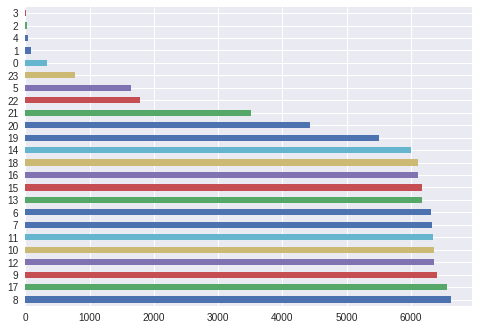

In [44]:
new_train['Hour'].value_counts().plot.barh();

In [0]:
from sklearn.preprocessing import LabelBinarizer
from numpy import hstack

In [0]:
lb = LabelBinarizer()
X_train = lb.fit_transform(new_train['Month'])
X_test = lb.transform(new_test['Month'])

In [47]:
lb = LabelBinarizer(sparse_output=False)
for col in list(new_train.drop(columns=['Distance', 'dep_delayed_15min', 'Month'],axis=1).columns):
    X_train = np.hstack([X_train, lb.fit_transform(new_train[col])])
    X_test = np.hstack([X_test, lb.transform(new_test[col])])
    print('col', col, lb.fit_transform(new_train[col]).shape, 'X_train=', X_train.shape, 'X_test=', X_test.shape)

col DayofMonth (100000, 31) X_train= (100000, 43) X_test= (100000, 43)
col DayOfWeek (100000, 7) X_train= (100000, 50) X_test= (100000, 50)
col UniqueCarrier (100000, 22) X_train= (100000, 72) X_test= (100000, 72)
col Origin (100000, 289) X_train= (100000, 361) X_test= (100000, 361)
col Dest (100000, 289) X_train= (100000, 650) X_test= (100000, 650)
col Hour (100000, 24) X_train= (100000, 674) X_test= (100000, 674)
col Min (100000, 60) X_train= (100000, 734) X_test= (100000, 734)


In [0]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [0]:
X_train = np.hstack([X_train, new_train['Distance'].reshape(100000, 1)])
X_test = np.hstack([X_test, new_test['Distance'].reshape(100000, 1)])

In [50]:
print(X_train.shape, X_test.shape)

(100000, 735) (100000, 735)


In [0]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

In [52]:
from sklearn.model_selection import GridSearchCV
params = {'C':[0.1, 0.3, 0.5, 1, 2, 5, 10, 15]}
lr = LogisticRegression()
gcv = GridSearchCV(lr, scoring='roc_auc', param_grid=params)
gcv.fit(X_train_part, y_train_part)
gcv.best_params_

{'C': 0.1}

In [53]:
gcv.best_score_

0.7221514219657805

In [77]:
lr_train_part = LogisticRegression(C=0.1).fit(X_train_part, y_train_part)
lr_valid_pred = lr_train_part.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, lr_valid_pred)

0.7168714205636932

In [0]:
xgb_train_part = XGBClassifier(max_depth=12, learning_rate=0.02, n_estimators=500)

In [71]:
xgb_train_part.fit(X_train_part, y_train_part)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [72]:
xgb_valid_pred = xgb_train_part.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, xgb_valid_pred)

0.7365406666399483

In [78]:
from numpy import arange
best_w = -0.1
best_auc = -0.1
for w in arange(0, 1.1, 0.1):
  combine_pred = w*lr_valid_pred + (1-w)*xgb_valid_pred
  auc = roc_auc_score(y_valid, combine_pred)
  if auc > best_auc:
    best_w = w
    best_auc = auc
print(best_w, best_auc)

0.1 0.7369555906440532


In [32]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(xgb_train_part, X_train_part, y_train_part, scoring='roc_auc'))

0.7408017528640102

In [56]:
xgb_model.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
lr_model = LogisticRegression(C=0.1).fit(X_train, y_train)
lr_predict = lr_model.predict_proba(X_test)


In [0]:
xgb_predict = xgb_model.predict_proba(X_test)

In [0]:
combine_pred = best_w*lr_predict + (1-best_w)*xgb_predict

In [85]:
combine_pred.dtype

dtype('float64')

In [0]:
combine_pred = [predict[1] for predict in combine_pred]

In [0]:
combine_pred=np.array(combine_pred)

In [0]:
def write_to_submission_file(predicted_labels, out_file,
                             target='dep_delayed_15min', index_label="id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [0]:
write_to_submission_file(combine_pred,"combine_predict.csv")

In [0]:
files.download("combine_predict.csv")
